# Pypianoroll
[公式](https://salu133445.github.io/pypianoroll/index.html)  
ISMIRで2018年に発表されたMIDIのピアノロール操作に重点を置いたライブラリ  
MuseGANの人たちが作ってる

## 基本的な使い方

### 基本的なオブジェクト
主なPypianorollのオブジェクトは
- [Track](https://salu133445.github.io/pypianoroll/track.html#track): ピアノロール行列とメタデータ(プログラムナンバーや楽器名など)
- [Multitrack](https://salu133445.github.io/pypianoroll/multitrack.html#multitrack): Trackのリストとメタデータ(テンポや曲名など)

楽器のプログラムナンバーやドラムのキーマップは[GM1 Sound Set](https://www.midi.org/specifications/item/gm-level-1-sound-set)を参照

### 使い方の例

In [1]:
import numpy as np
import pypianoroll
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

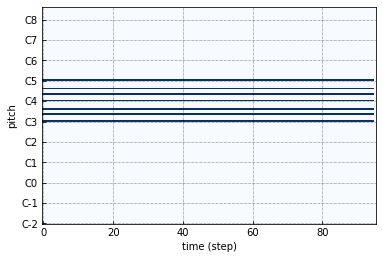

In [2]:
# ピアノロール行列を作成, (時間, 音程)
pianoroll = np.zeros((96, 128))
C_maj = [60, 64, 67, 72, 76, 79, 84] # Cコード
pianoroll[0:95, C_maj] = 100

# Trackインスタンスを作成
track = Track(pianoroll=pianoroll, program=0, is_drum=False, name='piano')

# プロットもできる
fig, ax = track.plot()
plt.show()

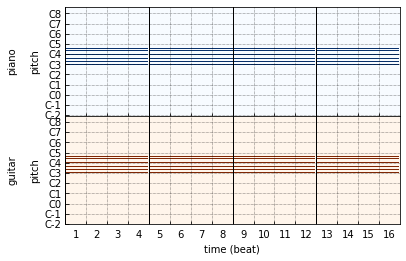

In [3]:
# 先ほどのコードを4小節伸ばす
track.pianoroll = np.tile(track.pianoroll, (4, 1)) # 横に4回縦に1回繰返す
downbeats = [96 * i for i in range(4)] # 4つの小説の区切りステップ位置

# トラックをコピーし，ギターの音にする
another_track = track.copy()
another_track.program = 24
another_track.name = 'guitar'

# ピアノとギターを合わせてマルチトラックにする
multitrack = Multitrack(
    tracks=[track, another_track], 
    tempo=120.0, 
    downbeat=downbeats,
    beat_resolution=24 # 24タイムステップで一拍
)

# マルチトラックのプロット
fig, axs = multitrack.plot()
plt.show()

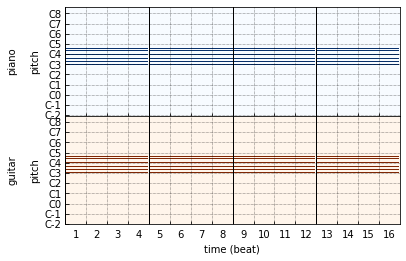

In [4]:
# npzデータとしての保存と読み込み
test_data = './data/test.npz'
multitrack.save(test_data)
loaded = Multitrack(test_data)
loaded.plot()
plt.show()

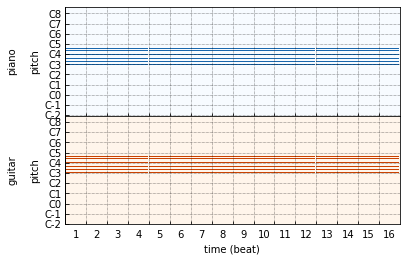

In [5]:
# MIDIデータとしての保存と読み込み
test_midi = './midi/test.mid'
multitrack.write(test_midi)
another_multitrack = Multitrack(test_midi)
another_multitrack.plot()
plt.show()

作成されたMIDIは無事再生できた

lmdのトラック読み込みも可能

In [6]:
lmd_midi = "./midi/a.mid"
lmd = Multitrack(lmd_midi)
print("# of instruments:", len(lmd.tracks))

# of instruments: 17


main_synthの最初の4小節を表示してみる

instrument 0: main synth          
pianoroll size: (10464, 128)
program number: 62


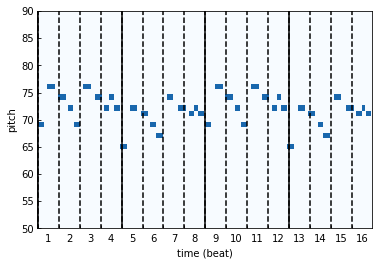

In [7]:
main_synth = lmd.tracks[0]
print("instrument 0:", main_synth.name)
print("pianoroll size:", main_synth.pianoroll.shape)
print("program number:", main_synth.program)

main_synth_copy = main_synth.copy()

bars = 4
beat_res = lmd.beat_resolution
bar_res = beat_res * 4

main_synth_copy.pianoroll = main_synth.pianoroll[:bar_res * bars]

fig, ax = main_synth_copy.plot(ytick="pitch", beat_resolution=beat_res)
for i in range(bars):
    plt.vlines(bar_res * i, 0, 127)
    for j in range(4):
        plt.vlines(bar_res * i + beat_res * j, 0, 127, linestyles='dashed')
plt.ylim(50, 90)
plt.grid(False)

## 保存と読み込み
ピアノロールのデータとしてのセーブは，まず`scipy.sparse.csc_matrix`に変換されてから保存される．  
ピアノロールは基本的にスパースなデータだからである．

#### pypianoroll.save(filepath, obj, compressed=True)
objはMultitrackオブジェクトである必要がある  
セーブされるnpzファイルは以下のもので構成される
- ピアノロールのデータ(スパースマトリクス)
    - pianoroll_[index]_csc_data.npy
    - pianoroll_[index]_csc_indices.npy
    - pianoroll_[index]_csc_indptr.npy
- tempo.npy: テンポ配列
- downbeat.npy: 小節区切り線
- info.json: メタデータとトラック情報をまとめたJSONファイル

#### pianoroll.load(filepath)
npzファイルをMultitrackオブジェクトとしてロード

## パースと書き出し
MIDIファイルとしての読み書きについて  
`pretty_midi`に基づいているため，この機能を使う際はpretty_midiについての表示を[ここ](http://craffel.github.io/pretty-midi/)にしたがって行うこと

#### pypianoroll.parse(filepath, beat_resolution=24, name='unknown')
MIDIファイルをMultitrackオブジェクトとして読み込む

#### pypianoroll.write(obj, filepath)
MIDIファイルとしての書き出し  
テンポ変化や拍子変化はまだサポートされていないので注意

## 可視化
TrackやMultitrackの`plot()`には色々と専用オプションがある．  
- beat_resolution: 設定するとx軸をbeat数にできる
- downbeats: そのタイムステップが小節の一番最初であるかを指定するリスト
- preset: default, plain(軸なし), frame(tickなし)
- cmap: matplotlib.color.Colormap(=Blues)
- xtick: auto, beat, step, off
- ytick: octave, pitch(番号), off
- xticklabel: bool
- yticklabel: auto, name, number, off
- tick_loc: bottom, top, left, right, defaultは(bottom, left)
- tick_direction: 目盛り線の有無, in, out, inout, defaultはin
- label: x, y, both, off
- grid: x, y, both, off
- grid_linestyle: linestyle
- grid_linewidth: linewidth

## ユーティリティ
MIDIファイルを扱う便利関数．pypianorollに用意されている．  
基本的に入力オブジェクトは変更されず，変更されたコピーが返される

#### check_pianoroll(arr)
ピアノロール行列ならTrue,そうでなければFalse,numpy行列でなければTypeError

#### binarize(obj, threshold=0)
True,Falseに2値化されたオブジェクトを返す．  
thresholdを上げるとそれよりベロシティの小さな音符を無視できる

#### clip(obj, lower=0, upper=127)
pitchをクリップする

#### copy(obj)
オブジェクトのコピーを返す

#### pad(obj, pad_length)
pad_lengthだけ後ろを0で埋めたピアノロールを返す．  
空白部分を後ろに追加することになる

#### pad_to_multiple(obj, factor)
factorの倍数の長さにして伸びた分を0で埋めたピアノロールを返す

#### pad_to_same(obj)
Multitrackの尻が揃うように0埋めを行う

#### transpose(obj, semitone)
カラオケみたいにトランスポーズ

#### trim_trailing_silence(obj)
後ろから何もないタイムステップを全て削除

## 評価基準
`pypianoroll.metrics`に，MuseGANの論文でも使用されている，MIDIデータの評価基準を測定できる関数が用意されている

#### empty_beat_rate(pianoroll, beat_resolution)
与えられたピアノロールの空白の拍の割合を返す

#### n_pitches_used(pianoroll)
与えられたピアノロールの中で使われている音程の種類数を返す

#### n_pitche_classes_used(pianoroll)
与えられたピアノロールで使われている音程の種類数(オクターブ違いも同じ音程とする)を返す  
はずなんだけど怪しい…(なぜ64(E3)と85(C5)がひとまとまりにできるのか？)

#### qualified_note_rate(pianoroll, threshold=2)
時間ステップをthreshold個使っている音符の割合．短すぎる音符がダメ

#### polyphonic_rate(pianoroll, threshold=2)
ピアノロールの中で，threshold種類の音符が同時に鳴っている時間ステップの割合

#### drum_in_pattern_rate(pianoroll, beat_resolution, tolerance=0.1)
全ドラム音符のうち，拍の上でピッタリ鳴っているドラム音符の割合  
toleranceは拍ピッタリで鳴っているとき1なのに対し，拍の周囲で音符が鳴っているとき，どれだけ点数を与えてやるかを意味する．

#### in_scale_rate(pianoroll, key=3, kind='major')
スケール上で鳴っている音符の割合  
keyは0がAで0~11，kindはmajorかminor，デフォルトはCメジャースケール

#### tonal_distance(pianoroll_1, pianoroll_2, beat_resolution, r1=1.0, r2=1.0, r3=0.5)
[Detecting harmonic change in musical audio](http://rose.ofai.at/~martin.gasser/papers/oefai-tr-2006-13.pdf)で提案された，2つのピアノロールの調和の度合いを測る指標．  
distanceなので，大きいほど調和していない．  
割かし難しそうなのでいつか読もう

## 単一トラックピアノロールオブジェクト
#### pypianoroll.Track(pianoroll=None,program=0,is_drum=False,name='unknown')
単一トラックピアノロールオブジェクトを生成  

### アトリビュート
- pianoroll: numpy配列，(num_time_step, 128)
- program: MIDIの楽器番号, 0~127, PC#から1引いたもの
- is_drum: パーカッショントラックであることを示す
- name: トラックの名前

### メソッド
- assign_constant(value, dtype=None): 音符の値をすべてvalue(数値)にする
- binarize(threshold=0): thresholdを超える値の音符をT，そうでないところをFにする
- check_validitiy(): 不正な属性があったらエラーを吐く
- clip(lower=0, upper=127): 音程をクリップ
- copy(): トラックのコピーを返す
- get_active_length(): trailing spaceを除く長さを返す
- get_active_pitch_range(): 音程のlowestとhighestを返す
- get_pianoroll_copy(): ピアノロールのコピーを返す
- is_binarized(): ピアノロールが二値化されているかどうか
- pad(pad_length): pad_lengthだけ0で埋めて伸ばしたトラックを返す
- pad_to_multiple(factor): factorの倍数の長さになるようトラックを0埋めで伸ばす
- plot(): pyplotで可視化
- transpose(semitone): トランスポーズする．-11~11
- trim_trailing_silence(): trailing spaceを削除する

## 複数トラックピアノロールオブジェクト
#### pypianoroll.Track(filename=None, tracks=None, tempo=120.0, downbeat=None, beat_resolution=24, name='unknown')
複数トラックピアノロールオブジェクトを作成  
初期化の際，ファイルパス文字列が渡されていれば，beat_resolution以外は無視される  
npzファイルやMIDIファイルをパースすることでも生成できる

### アトリビュート
- tracks: Trackオブジェクトのリスト
- tempo: (n_time_steps,), float, 各タイムステップにおけるテンポ．数値での一括設定でも可能(?)
- downbeat: (n_time_steps,), bool, 小節の先頭のタイムステップであるかを示す配列
- beat_resolution
- name

### メソッド
get_pianoroll_copy()がget_stacked_pianoroll()になっている以外はTrackの全てのメソッドが使える  
それに加えて，以下のメソッドを持つ
- append_track(track=None, pianoroll=None, program=0, is_drum=False, name='unknown')
- count_downbeat(): downbeatがTrueになっているところの数，すなわち小節数
- get_downbeat_steps(): downbeatがTrueになっているところの時間ステップリスト
- get_empty_tracks(): ピアノロールが空のトラックのインデックスリスト
- get_max_length(): 各ピアノロールの中で最大の時間ステップ数を返す
- get_stacked_pianoroll(): (n_time_steps, 128, n_tracks)のピアノロールを得る
- get_merged_pianoroll(mode='sum'): 重なる音符はmode=sum,max,any(binarize)で処理
- merge_tracks(track_indices=None, mode='sum', program=0, is_drum=False, name='merged', remove_merged=False)
- pad_to_same(): 0埋めで尻をそろえる
- remove_empty_tracks()
- remove_tracks(track_indices)

  
- save(filename, compressed=True): npzファイルへ書き出し
- load(filename): npzファイルの内容を反映

  
- write(filename): MIDIファイルへ書き出し
- parse_midi(filename, \*\*kwargs): MIDIファイルの内容を反映

  
- to_pretty_midi(constant_tempo=None, constant_velocity=100): pretty_midiオブジェクトを得る
- parse_pretty_midi(pm, mode='max', algorithm='normal', binarized=False, skip_empty_tracks=True, collect_onsets_only=False, threshold=0, first_beat_time=None): pretty_midiオブジェクトの内容を反映

parse_pretty_midiは2つのモード，3つのアルゴリズムを選択できる  
mode: ndarrayにするとき重なった音符をどう処理するか
- max: 重なっている音符のベロシティが大きな方を採用する
- sum: 重なっている音符のベロシティの総和を取る

algorithm: 最初の拍の位置を取得する方法を指定する
- normal: pretty_midiの`estimate_beat_start()`を使用
- strict: 最初のtime signatureが設定されている位置を採用
- custom: 引数のfirst_beat_time(float)に書かれた最初の拍の位置を採用